# Fit using general zeta function

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [3]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,coefs):
    """x = 1/nv"""
    a1,a2 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2))


def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct

In [6]:
def residuals_func(coefs,x,fi,fi_err=None):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns a value with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    Args:
        coefs: Tuple: Parameters to be adjusted of the model
        x: float: Independent variable
        fi: float: Experimental value to adjust, also call y_i
        fi_err: Error for the experimental value, also call y_err_i
    Returns:
        residuals: float: Difference of the model evaluation and expected value
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    if fi_err is not None:
        residuals = fi - model_function(
            x,
            coefs
        ) / fi_err
        
        return residuals
    else:
        residuals = fi - model_function(
            x,
            coefs
        )
        
        return residuals


def get_residuals_func_sum_sqr(x_data,y_data,y_data_err=None):
    def residuals_func_sum_sqr(coefs):
        """Calculate the sum of the squared residuals."""
        result = 0
        num_el = len(x_data)
        for index in range(num_el):
            if y_data_err is not None:
                result = result + residuals_func(coefs,x_data[index],y_data[index],y_data_err[index])**2
            else:
                result = result + residuals_func(coefs,x_data[index],y_data[index])**2
        return result

    return residuals_func_sum_sqr

## Read files

In [10]:
# get inv_temp
data_path = Path("../../data/regular/infinite-size").resolve()
file = 'regular_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))
# get uncert inv_temp
file_err = 'regular_all_inv_Tc_uncertainty.csv'
df_all_tc_err = pd.read_csv(os.path.join(data_path,file_err))

In [18]:
df_params = pd.DataFrame(index=["a1","a2","a1_err","a2_err"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

1.0
      fun: 0.004316369597760562
 hess_inv: array([[  1.85095599, -20.24066065],
       [-20.24066065, 227.93957293]])
      jac: array([ 1.55880116e-07, -3.71946953e-08])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([0.42832795, 3.02261581])
Best fit parameters: [0.42832795 3.02261581]


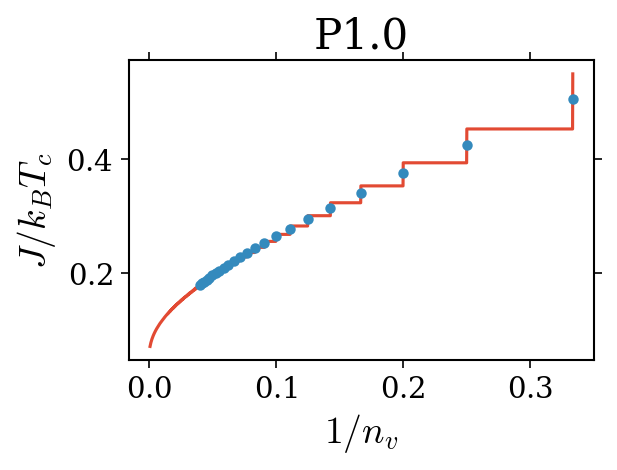

---------------------------------------------
coefs:[0.42832795 3.02261581]
---------------------------------------------
min:0.07164354536675412 at 0.001
fit at 1/nv=1: 1.2946708244326717


1.05
      fun: 0.0041968937105196875
 hess_inv: array([[  1.68630381, -16.91319636],
       [-16.91319636, 174.71406056]])
      jac: array([-1.70024578e-06, -2.45461706e-07])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([0.42633669, 2.87799957])
Best fit parameters: [0.42633669 2.87799957]


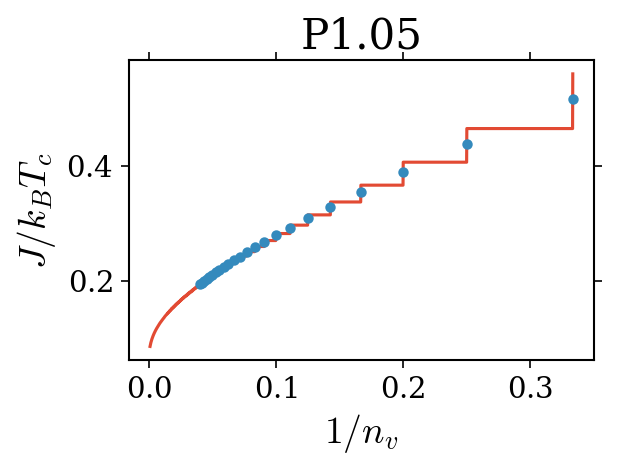

---------------------------------------------
coefs:[0.42633669 2.87799957]
---------------------------------------------
min:0.08547574201771563 at 0.001
fit at 1/nv=1: 1.2935939229151465


1.1
      fun: 0.004077013483139669
 hess_inv: array([[  1.6309912 , -15.06891709],
       [-15.06891709, 143.04335247]])
      jac: array([4.42279270e-06, 4.11062501e-07])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([0.42407484, 2.7544765 ])
Best fit parameters: [0.42407484 2.7544765 ]


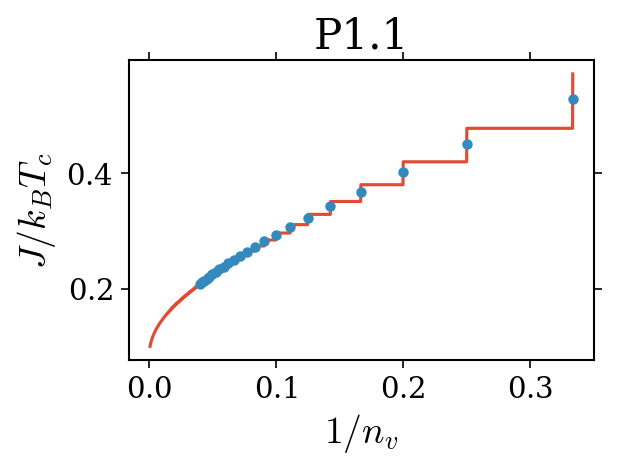

---------------------------------------------
coefs:[0.42407484 2.7544765 ]
---------------------------------------------
min:0.10095886348114722 at 0.001
fit at 1/nv=1: 1.2926635049612416


1.2
      fun: 0.0035223115103833616
 hess_inv: array([[  1.61029542, -12.4048239 ],
       [-12.4048239 ,  97.82343398]])
      jac: array([-2.29076250e-07, -1.86846592e-08])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([0.42555874, 2.49558026])
Best fit parameters: [0.42555874 2.49558026]


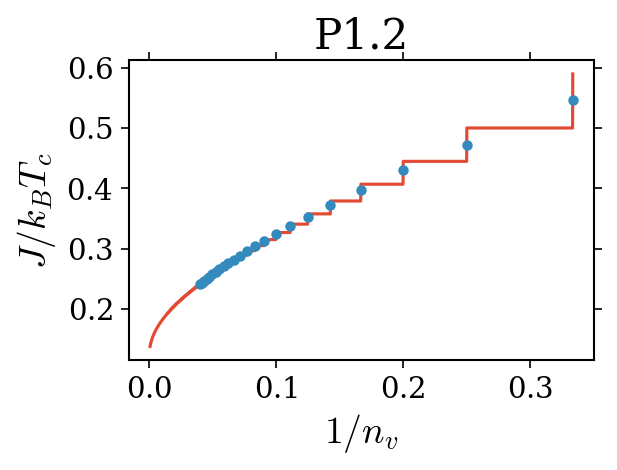

---------------------------------------------
coefs:[0.42555874 2.49558026]
---------------------------------------------
min:0.137774759667001 at 0.001
fit at 1/nv=1: 1.275162007587093


1.3
      fun: 0.0036449493853894332
 hess_inv: array([[  1.50654521, -10.36759017],
       [-10.36759017,  72.81801451]])
      jac: array([5.62053174e-07, 1.28464308e-07])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([0.41754724, 2.36799082])
Best fit parameters: [0.41754724 2.36799082]


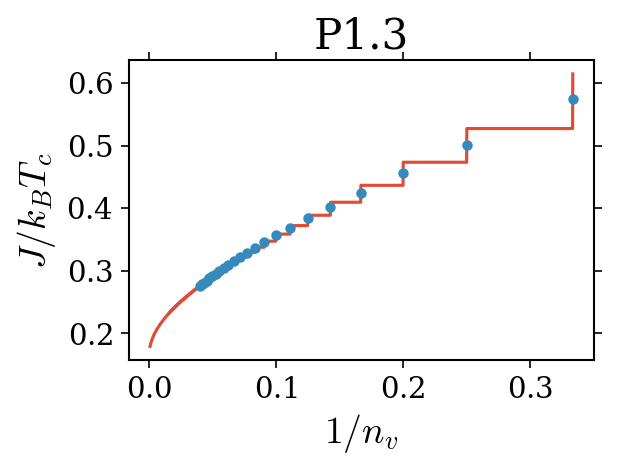

---------------------------------------------
coefs:[0.41754724 2.36799082]
---------------------------------------------
min:0.17905306415432826 at 0.001
fit at 1/nv=1: 1.280559128543763


1.4
      fun: 0.003225089305429059
 hess_inv: array([[ 1.4798051 , -8.85101608],
       [-8.85101608, 53.79515084]])
      jac: array([-1.04491482e-06, -1.76252797e-07])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([0.41462357, 2.23104386])
Best fit parameters: [0.41462357 2.23104386]


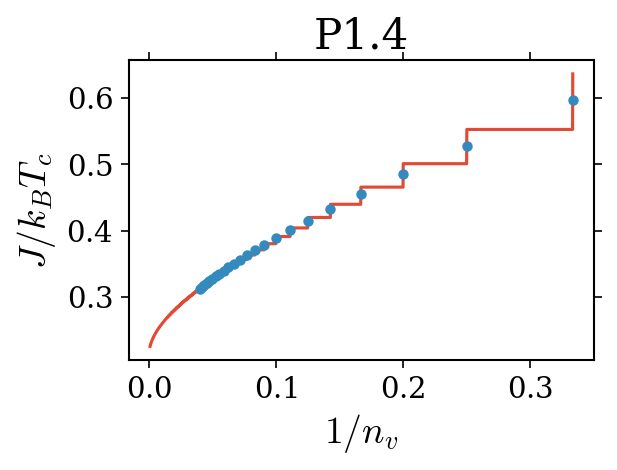

---------------------------------------------
coefs:[0.41462357 2.23104386]
---------------------------------------------
min:0.22593950166944785 at 0.001
fit at 1/nv=1: 1.2751619338809066


1.5
      fun: 0.0028655883820655217
 hess_inv: array([[ 1.59361455, -8.26658063],
       [-8.26658063, 43.45461155]])
      jac: array([-8.56569386e-06, -1.45231024e-06])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([0.41474318, 2.10292122])
Best fit parameters: [0.41474318 2.10292122]


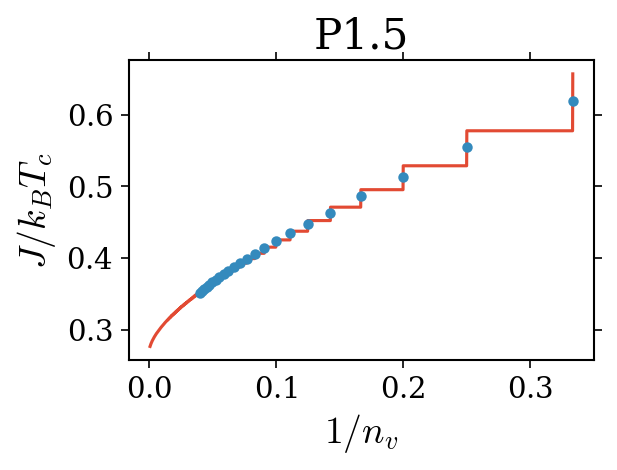

---------------------------------------------
coefs:[0.41474318 2.10292122]
---------------------------------------------
min:0.2767068078693635 at 0.001
fit at 1/nv=1: 1.2647764005024917


1.6
      fun: 0.0026621192719989304
 hess_inv: array([[ 1.71699673, -7.71510256],
       [-7.71510256, 35.01337821]])
      jac: array([-1.61060598e-06, -3.40631232e-07])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 19
     njev: 23
   status: 0
  success: True
        x: array([0.41839131, 1.98213889])
Best fit parameters: [0.41839131 1.98213889]


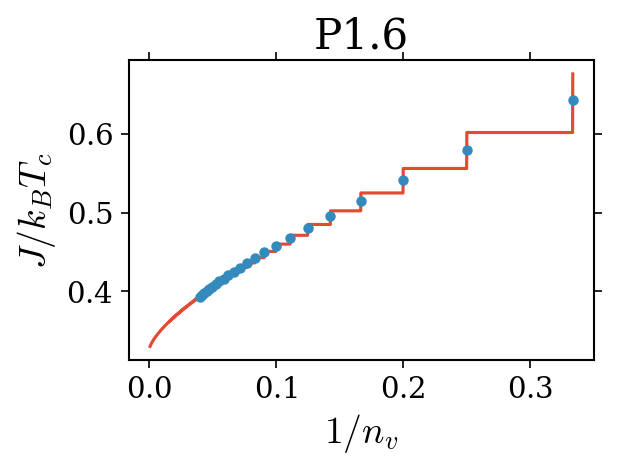

---------------------------------------------
coefs:[0.41839131 1.98213889]
---------------------------------------------
min:0.3299142934045202 at 0.001
fit at 1/nv=1: 1.2502509228061616


1.7
      fun: 0.0023850446576298714
 hess_inv: array([[ 2.07642258, -7.96445692],
       [-7.96445692, 30.7863617 ]])
      jac: array([5.30155376e-07, 1.25612132e-07])
  message: 'Optimization terminated successfully.'
     nfev: 140
      nit: 26
     njev: 35
   status: 0
  success: True
        x: array([0.42509241, 1.87200893])
Best fit parameters: [0.42509241 1.87200893]


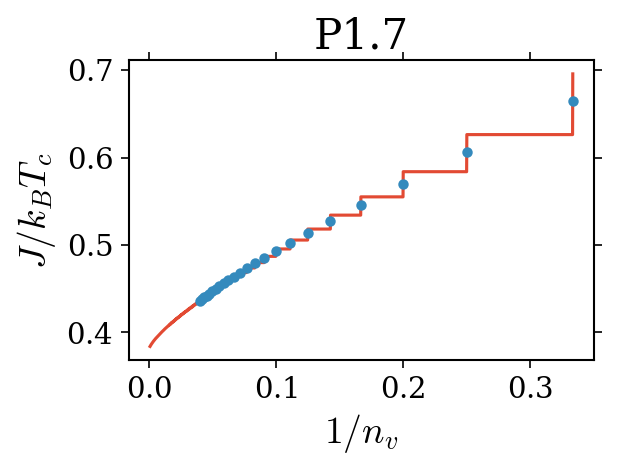

---------------------------------------------
coefs:[0.42509241 1.87200893]
---------------------------------------------
min:0.3840311348431822 at 0.001
fit at 1/nv=1: 1.2342604533204566


1.8
      fun: 0.002129466725249663
 hess_inv: array([[ 2.606693  , -8.45763445],
       [-8.45763445, 27.59877354]])
      jac: array([ 5.06406650e-09, -7.85803422e-10])
  message: 'Optimization terminated successfully.'
     nfev: 136
      nit: 27
     njev: 34
   status: 0
  success: True
        x: array([0.43728836, 1.76361483])
Best fit parameters: [0.43728836 1.76361483]


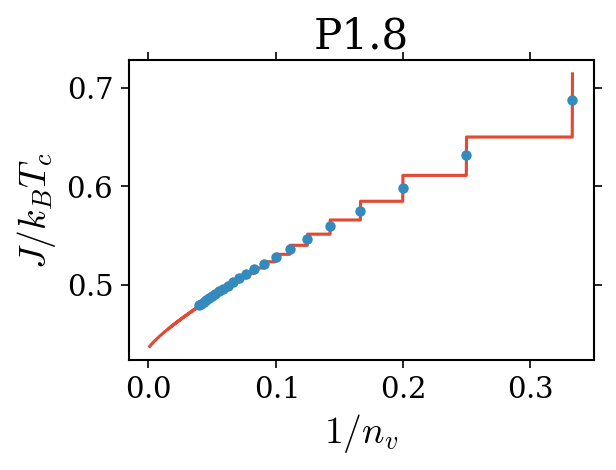

---------------------------------------------
coefs:[0.43728836 1.76361483]
---------------------------------------------
min:0.4380788668413833 at 0.001
fit at 1/nv=1: 1.214212361849888


1.9
      fun: 0.0019495484883860304
 hess_inv: array([[ 3.49950573, -9.51798844],
       [-9.51798844, 25.99277361]])
      jac: array([8.46441253e-07, 1.07000233e-07])
  message: 'Optimization terminated successfully.'
     nfev: 144
      nit: 25
     njev: 36
   status: 0
  success: True
        x: array([0.45377405, 1.66385516])
Best fit parameters: [0.45377405 1.66385516]


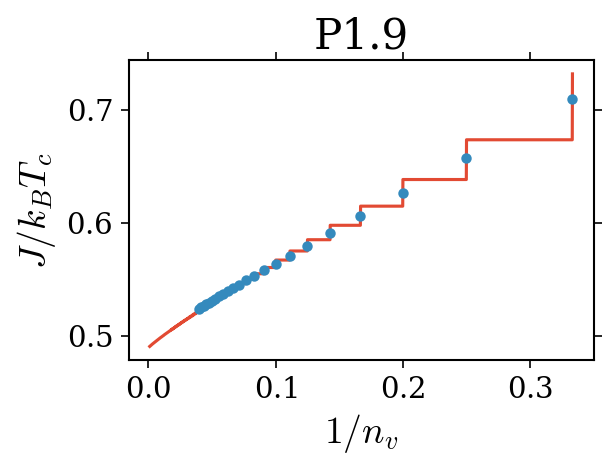

---------------------------------------------
coefs:[0.45377405 1.66385516]
---------------------------------------------
min:0.49075759020123616 at 0.001
fit at 1/nv=1: 1.1938757723108286


2.0
      fun: 0.0019545706911593534
 hess_inv: array([[  5.05233497, -11.43793666],
       [-11.43793666,  25.96634098]])
      jac: array([9.00414307e-07, 3.70375346e-07])
  message: 'Optimization terminated successfully.'
     nfev: 148
      nit: 29
     njev: 37
   status: 0
  success: True
        x: array([0.47590083, 1.56987875])
Best fit parameters: [0.47590083 1.56987875]


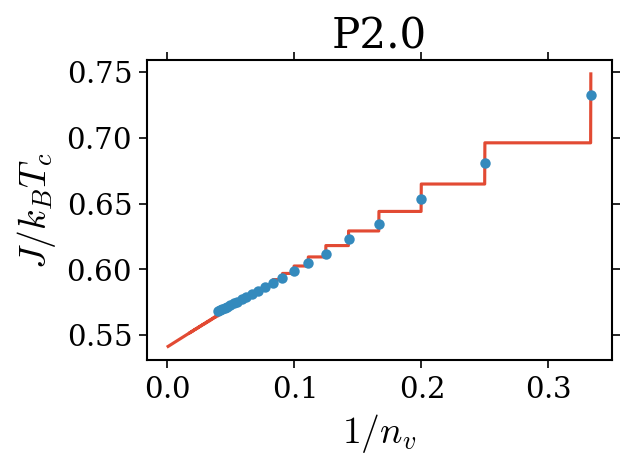

---------------------------------------------
coefs:[0.47590083 1.56987875]
---------------------------------------------
min:0.5413246817664523 at 0.001
fit at 1/nv=1: 1.1728667863163353




In [20]:
epsilon = 0.0001
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
# COLUMNS = ["P1.05"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus'
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    print(p)
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
#     # add value at nv=1
#     x_data = np.concatenate([x_data,[1]])
#     y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0)
#         y_data = np.insert(y_data,0,0)
        
    # fit 
    best_fit_result = minimize(residuals_func_sum_sqr,
                               x0=(1,1.5),
                              )
    print(best_fit_result)
    best_fit_coefs = best_fit_result.x
    print("Best fit parameters:", best_fit_coefs)

#     (a1,a2) = best_fit_coefs 
    df_params[COLUMN] = best_fit_coefs
    extrapol_funct = get_extrapol_function(model_function, best_fit_coefs)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1/3, 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
#     ax.text(0.1, 0.2, r"$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$",
#            fontsize=8)

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("coefs:{}".format(best_fit_coefs))
    print("---------------------------------------------")
    df_extrapol_val[COLUMN] = [extrapol_funct(0+epsilon),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))
    print("fit at 1/nv=1: {}".format(extrapol_funct(1)))
    print("\n")

In [33]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [211]:
print(np.arange(1,2.1,0.1))
print(1.036694*zeta(np.arange(1,2.1,0.1),1.005401))

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
[        inf 10.96326581  5.78679131  4.06585347  3.20871592  2.69703051
  2.35801395  2.1176159   1.938811    1.80102955  1.69192972]


In [34]:
1/df_extrapol_val

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
infty,inf,40.802462,20.001048,9.695783,6.289980,4.642782,3.664966,3.028432,2.584630,2.260974,2.016436,1.828035
1,0.853717,0.849649,0.846321,0.839732,0.841365,0.838389,0.842588,0.849798,0.860599,0.874991,0.894473,0.917324


In [228]:
df_params

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,0.590458,0.566803,0.619079,0.653618,0.680352,0.709632,0.739893,0.772791,0.814791,0.838970,0.871035,0.902332
a2,1.000000,1.071500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a3,0.623776,0.718472,0.621406,0.575120,0.563507,0.538141,0.503855,0.439844,0.249091,0.284501,0.202951,0.109387
a4,0.270842,0.000000,0.212115,0.253768,0.276282,0.274676,0.256820,0.328395,1.138831,0.538051,0.609852,0.765293
a5,-1.399915,-1.439168,-1.353404,-1.360142,-1.486767,-1.487669,-1.406711,-1.396617,-2.877294,-1.466223,-1.356896,-1.443215
a6,1.114421,1.311838,1.100362,1.077245,1.166196,1.164799,1.105737,1.055183,1.874199,1.004249,0.872571,0.865691


In [35]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_5plus'

In [36]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
a1  0.479273  0.474726  0.470561  0.462237  0.459409  0.454393  0.455685   
a2  2.444011  2.374326  2.309399  2.200368  2.077546  1.992386  1.892984   

        P1.6      P1.7      P1.8      P1.9      P2.0  
a1  0.461297  0.473012  0.492477  0.524264  0.570894  
a2  1.795518  1.696695  1.596308  1.489691  1.381850  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_5plus_params_curves.csv
           P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
infty  0.000000  0.024508  0.049997  0.103138  0.158983  0.215388  0.272854   
1      1.171349  1.176957  1.181585  1.190856  1.188545  1.192764  1.186820   

           P1.6      P1.7      P1.8      P1.9      P2.0  
infty  0.330204  0.386903  0.442287  0.495924  0.547036  
1      1.176750  1.161981  1.142869  1.11

## Plot extrapol values

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


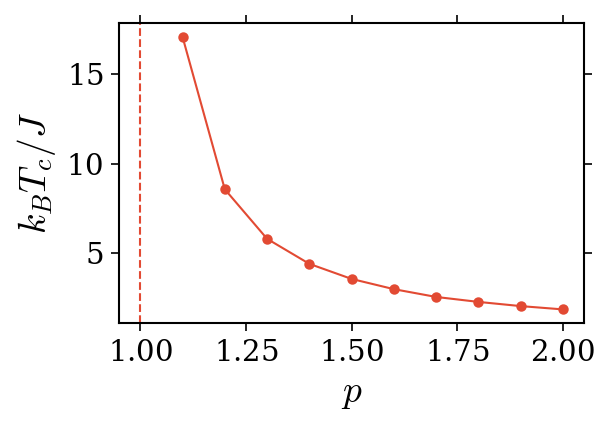

In [233]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values
y_data = np.delete(y_data,1)
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()

In [44]:
help(ax.text)

Help on method text in module matplotlib.axes._axes:

text(x, y, s, fontdict=None, withdash=<deprecated parameter>, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Add text to the axes.
    
    Add the text *s* to the axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : scalars
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Returns
    -------
    text : `.Text`
        The created `.Text` instance.
   